<a href="https://colab.research.google.com/github/Fr33zz/mw/blob/master/pobeda_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
from pandas.io.json import json_normalize

from google.colab import drive
drive.mount('/content/drive')

In [0]:
def g(x):
  type_d = {'OZON.travel'       :'segments',
            'Uzbekistan Airways':'segments',
            'Mego.travel'       :'segments',
            'Аэротур'           :'segments',
            'Aviakassa.com'     :'segments',
            'City.Travel'       :'segments',
            'UFS.Travel'        :'segments',
            'Азимут'            :'description',
            'Biletix'           :'description',
            'Связной Трэвел'    :'description',
            'Andgo.travel'      :'andgo',
            'Круизный дом'      :'cruise'}

  t = type_d[x['name']]
  number = np.nan
  try:
    if t=='segments':
      flights  = json.loads(x['partner_request'])['product']['segments']
      dep_time = flights[0]['flights'][0]['departure_dt']   
      date = dep_time.split('T')[0].split('-')
      time = dep_time.split('T')[1].split(':')
      dep_time = pd.datetime(day= int(date[2]),month= int(date[1]),year= int(date[0]), hour= int(time[0]), minute= int(time[1]))          
      number = len(json.loads(x['partner_request'])['product']['segments'])
    if t=='description':
      flights  = json.loads(x['partner_request'])['description']
      dep_time = json.loads(x['partner_request'])['departure_time']
      if dep_time == '':
        i = flights.split(', ')[-1].split(' -')[0].split('.')
        dep_time = pd.datetime(day=int(i[0]), month=int(i[1]), year=int(i[2]))
      number = len(json.loads(x['partner_request'])['description'].split(sep=',')[1:-2])
    if (t=='andgo') or (t=='cruise'):
      flights  = 'no_data'
      dep_time = ''
    pass
  except:
    flights   = 'err'
    dep_time  = ''
    pass
  x['flights'] = flights
  x['dep_time'] = dep_time
  x['format'] = t
  x['number'] = number
  return x

In [0]:
def g1(x):
  try:
    if x['format']=='segments':
      airports = [(i['flights'][0]['dest'], i['flights'][0]['orig']) for i in x['flights']]
    if x['format']=='description':
      z = x['flights'].split(sep=' - ')
      if z[0] =='err':
        airports = ['err']
      else:
        sf1 = lambda y: '{' + y.split(sep=',')[0].split(sep=' ')[-1] + ',' + y.split(sep=',')[1]+'}'
        sf2 = lambda y: '{' + y.split(sep=',')[0] + ',' + y.split(sep=',')[1] + '}'

        s3 = [sf1(z[i]) if i==0 else sf2(z[i]) if i==len(z)-2 else '{'+z[i]+'}' for i in range(len(z)-1) ] if (len(z)>2) else [sf1(z[0]) , sf2(z[1])]
        airports = [(s3[i-1], s3[i]) for i in range(1, len(s3))]
    if (x['format'] =='andgo') or (x['format'] =='cruise'): 
      airports = ['no_data']
    pass
  except:
    airports=['some error']
    pass
  x['airports'] = airports
  return x

In [0]:
def g2(x):
  for i in ['opened_at',	'closed_at',	'created_at', 'dep_time',  'birth_date']:
    x[i] = pd.to_datetime(x[i], errors='coerce', utc=True)

  def f1(x):
    try:
      return round(pd.to_timedelta(x['opened_at'] - x['birth_date'], unit='Y', errors='coerce').days/365)
      pass
    except:
      pass

  x['age'] = x.apply(f1, axis=1)

  def f1(x):
    try:
      return round(pd.to_timedelta(x['dep_time'] - x['opened_at'], unit='d', errors='coerce').days)
      pass
    except:
      pass

  x['days_to_flight'] = x.apply(f1, axis=1)

  x['year-month'] = x['opened_at'].dt.strftime('%Y-%m')
  x['year'] = x['opened_at'].dt.strftime('%Y')
  x['whole_time'] = x['opened_at'].map(lambda x: 'whole_time')
  return x

In [0]:
dm = pd.read_csv("/content/drive/My Drive/analytics/4 pobeda/data_mw.csv")


dm['international_passport'] = dm['international_passport_number'].notna()
dm['age'] = pd.to_datetime(dm['state'].map(lambda x: np.nan))
dm['days_to_flight'] = pd.to_datetime(dm['state'].map(lambda x: np.nan))

dm['male'] = dm['sex']=='male'
dm['female'] = dm['sex']=='female'

dm['flights'] = dm['state']
dm['dep_time'] = dm['state']
dm['format'] = dm['state']
dm['airports'] = dm['state']

dm = g2(dm.apply(g, axis=1).apply(g1, axis=1))

/usr/local/lib/python3.6/dist-packages/pandas/util/_decorators.py:208: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  return func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/tools/timedeltas.py:134: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  result = Timedelta(r, unit)


In [0]:
cols_to_show = ['year-month', 'masked_id', 'state', 'total_amount',
                'name', 'opened_at', 'sex', 'birth_date', 'postcode',
                'international_passport_number',
                'international_passport', 'age', 'days_to_flight',
                'dep_time', 'format', 'airports', 'number', 'male', 'female', 'year', 'whole_time']
       
ren_d = {'name':'partner', 
         'dep_time':'departure time',
         'airports':'flights',
         'number':'number of flights'}

In [0]:
da = pd.read_csv("/content/drive/My Drive/analytics/4 pobeda/data_at.csv").rename(columns={'name':'user_name'})

for i in ['opened_at',	'expires_at',	'date_closed',	'birthday', 'departure_date']:
  da[i] = pd.to_datetime(da[i], utc=True)
da.head()

da['international passport'] = da['document_type'] == 'foreign'
da['year-month'] = da['opened_at'].dt.strftime('%Y-%m')
da['year'] = da['opened_at'].dt.strftime('%Y')
da['whole_time'] = da['opened_at'].map(lambda x: 'whole_time')

da['age'] = round(pd.to_timedelta(da['opened_at'] - da['birthday'], unit='days').dt.days/365)
da['days_to_flight'] = pd.to_timedelta(da['departure_date'] - da['opened_at'], unit='days').dt.days

da['name'] = da['state'].map(lambda x: 'Andgo.travel')
da['active'] = da['state'].map(lambda x: True)
da['document_type']= da['document_type']=='foreign'
da['number'] = da['state'].map(lambda x: 1)
da['airports'] = da.apply(lambda x: [(x['departure_city_ru'], x['arrival_city_ru'])], axis=1)
da['format'] = da['state'].map(lambda x: 'andgo_original')

da.rename(columns={ 'date_closed':'closed_at', 
                    'total_cost':'total_amount',
                    'birthday':'birth_date',
                    'postal_code':'postcode',
                    'foreign_document_number':'international_passport_number',
                    'document_type':'international_passport',
                    'departure_date':'dep_time'}, inplace=True)

def f(x):
  if x['sex']==False:
    if x['gender']==2:
      return 'male'
    else:
      return 'female'
  else:
    if x['gender']==1:
      return 'female'
    else:
      return 'male'

da['sex'] = da['gender'].map(lambda x: 'male' if x==2 else 'female' if x==1 else 'other')

da['male']   = da['sex'] == 'male'
da['female'] = da['sex'] == 'female'

In [0]:
d = pd.concat([dm[cols_to_show], da[cols_to_show]])

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

aps = gc.open_by_url('https://docs.google.com/spreadsheets/d/1gWCGmzG3YdD7zo-HapJ4q39WHAk1u7a7Rq1qmZBTmYQ/edit#gid=1677366831')
aps = pd.DataFrame(aps.worksheets()[0].get_all_values())
aps = aps.rename(columns=aps.iloc[0]).drop(index=0).reset_index().drop(columns='index')

aps = aps[['iata_code', 'city_name_en', 'city_name_ru']]
aps = aps.drop(index=[502, 2824])

def f(x):
  if x['city_name_ru'] == '':
    if x['city_name_en'] == '':
      x['city_name_ru'] = x['iata_code']
    else:
      x['city_name_ru'] = x['city_name_en']
  return x

dict_seg = aps.apply(f, axis=1)[['iata_code', 'city_name_ru']].set_index('iata_code').to_dict()['city_name_ru']

In [0]:
def f(x):
  if (x['airports'][0]!='no_data')&(x['airports'][0]!='some_error')&(x['airports'][0]!='err'):
    try:
      airp = x['airports']
      if x['format']=='segments':
        airp = [(dict_seg[i[0]], dict_seg[i[1]]) for i in airp]
      if x['format']=='description':
        airp = [(i[0].split(',')[0].split('{')[1], i[1].split(',')[0].split('{')[1]) for i in airp]
      pass
    except:
      x['errors'] = 'err'
      pass
    x['airports'] = airp
  return x
  
d['errors'] = d['state'].map(lambda x: '')

d = d.apply(f, axis=1)
d['check*'] = d['total_amount'].map(lambda x: x/12.1*10)

In [0]:
other_part = ['OZON.travel', 'Andgo.travel', 'Biletix', 'Связной Трэвел',
              'Aviakassa.com', 'City.Travel','Круизный дом', 'Uzbekistan Airways',
              'Mego.travel', 'Аэротур']

all_part = ['OZON.travel', 'Andgo.travel', 'Biletix', 'Связной Трэвел',
            'Aviakassa.com', 'Азимут', 'City.Travel', 'UFS.Travel',
            'Круизный дом', 'Uzbekistan Airways', 'Mego.travel', 'Аэротур']

col_names = ['средний_чек','всего_клиентов', 'суммарный_чек',
             'женщины', 'мужчины', 'пол_неизвестен',
             'доля_женщин', 'доля_мужчин', 'доля_неизвестного_пола',
             'доля_с_заграном']             

periods = ['year-month', 'year', 'whole_time']

part_list = [all_part, ['Азимут'], ['UFS.Travel'], other_part] 
dict_part_list = {0:'_all', 1:'_azimuth', 2:'_ufs', 3:'_other'}

col_list = [i + dict_part_list[j] for i in col_names for j in range(4)]

dd   = [pd.DataFrame() for i in range(len(part_list))]
dper = [pd.DataFrame() for i in range(len(periods))]


In [0]:
for j in range(len(periods)):
  for i in range(len(part_list)):
    dd[i] = d[d['name'].isin(part_list[i])].pivot_table(index = periods[j], aggfunc={'check*':'sum',
                                                                                      'male':'sum',
                                                                                      'female':'sum',
                                                                                      'masked_id':'count',
                                                                                      'age':'mean',
                                                                                      #'days_to_flight':'mean',
                                                                                      'international_passport':'sum'})

    dd[i]['female_part']            = dd[i]['female']     / dd[i]['masked_id']
    dd[i]['male_part']              = dd[i]['male']       / dd[i]['masked_id']
    dd[i]['international_passport'] = dd[i]['international_passport'] / dd[i]['masked_id']
    dd[i]['average_check']          = dd[i]['check*']     / dd[i]['masked_id']
    dd[i]['no_sex']                 = dd[i]['masked_id'] -  dd[i]['male'] - dd[i]['female']
    dd[i]['no_sex_part']            = dd[i]['no_sex']    /  dd[i]['masked_id']

    dd[i].rename(columns = {'check*':'суммарный_чек'+dict_part_list[i],
                            'female':'женщины'+dict_part_list[i],
                            'international_passport':'доля_с_заграном'+dict_part_list[i],
                            'male':'мужчины'+dict_part_list[i],
                            'masked_id':'всего_клиентов'+dict_part_list[i],
                            'female_part':'доля_женщин'+dict_part_list[i],
                            'age':'средний_возраст'+dict_part_list[i],
                            'male_part':'доля_мужчин'+dict_part_list[i],
                            #'days_to_flight':'дней_до_вылета'+dict_part_list[i],
                            'average_check':'средний_чек'+dict_part_list[i],
                            'no_sex':'пол_неизвестен'+dict_part_list[i],
                            'no_sex_part':'доля_неизвестного_пола'+dict_part_list[i]}, inplace=True)
    
    dper[j] = pd.concat(dd,axis=1).T



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [0]:
def f1(x):
  try:
    if (x[0]!='err') & (x[0]!='no_data') & (x[0]!='some error'):
      return [[i[j] for i in x] for j in range(2)]
    else:
      return [x,x]
    pass
  except:
    return [x,x]
    pass
d['Departure cities'] = d['airports'].map(lambda x: f1(x)[0])
d['Arrival cities'] = d['airports'].map(lambda x: f1(x)[1])

In [0]:
l = ['средний_чек_all'
     ,'средний_чек_azimuth'
     ,'средний_чек_ufs'
     ,'средний_чек_other'
     ,'доля_мужчин_all'
     ,'доля_женщин_all'
     ,'доля_мужчин_azimuth'
     ,'доля_женщин_azimuth'
     ,'доля_мужчин_ufs'
     ,'доля_женщин_ufs'
     ,'доля_мужчин_other'
     ,'доля_женщин_other'
     ,'средний_возраст_all'
     ,'средний_возраст_azimuth'
     ,'средний_возраст_ufs'
     ,'средний_возраст_other'
     ,'доля_с_заграном_all'
     ,'доля_с_заграном_azimuth'
     ,'доля_с_заграном_ufs'
     ,'доля_с_заграном_other'
     #,'дней_до_вылета_all'
     #,'дней_до_вылета_azimuth'
     #,'дней_до_вылета_ufs'
     #,'дней_до_вылета_other'
     ,'всего_клиентов_all'
     ,'всего_клиентов_azimuth'
     ,'всего_клиентов_ufs'
     ,'всего_клиентов_other'
     ,'пол_неизвестен_all'
     ,'пол_неизвестен_azimuth'
     ,'пол_неизвестен_ufs'
     ,'пол_неизвестен_other'
     ,'доля_неизвестного_пола_all'
     ,'доля_неизвестного_пола_azimuth'
     ,'доля_неизвестного_пола_ufs'
     ,'доля_неизвестного_пола_other'
     ,'суммарный_чек_all'
     ,'суммарный_чек_azimuth'
     ,'суммарный_чек_ufs'
     ,'суммарный_чек_other'
     ]

In [0]:
ind = gc.open_by_url('https://docs.google.com/spreadsheets/d/1FPB2vzRZ72AZSExDTVjOmSiYoy3i5-TlLF_FNTn_iac/edit#gid=2017298626')
ind = pd.DataFrame(ind.worksheets()[0].get_all_values())
ind = ind.rename(columns=ind.iloc[0]).drop(index=0).reset_index().drop(columns='index')

#ind = ind.set_index('INDEX').to_dict()

In [0]:
def f(x):
  try:
    return int(x)
    pass
  except:
    pass

ind['INDEX'] = ind['INDEX'].map(f)
d['postcode'] = d['postcode'].map(f)

In [0]:
d = pd.merge(left=d, right=ind, how='left',left_on='postcode', right_on='INDEX', indicator=True)#.pivot_table(index='_merge', aggfunc={'masked_id':'count'})
d['REGION'] = d['REGION'].map(lambda x: [x])
#d[['postcode', 'INDEX', 'REGION']]

In [0]:
dya = [pd.DataFrame() for i in range(len(periods))]
for j in range(len(periods)):
  for i in range(len(part_list)):
    dd[i] = d[d['name'].isin(part_list[i])].pivot_table(index = periods[j], aggfunc={#'masked_id':'count',
                                                                                      'days_to_flight':'mean'})

    dd[i].rename(columns = {'days_to_flight':'дней_до_вылета'+dict_part_list[i]}, inplace=True)
    
    dya[j] = pd.concat(dd,axis=1).T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [0]:
with pd.ExcelWriter('/content/drive/My Drive/analytics/4 pobeda/data_2_pobeda_v1.xlsx') as writer:
    dper[0].T[l].T.to_excel(writer, sheet_name=periods[0])
    dper[1].T[l].T.to_excel(writer, sheet_name=periods[1])
    dper[2].T[l].T.to_excel(writer, sheet_name=periods[2])
    dya[0].to_excel(writer, sheet_name='days_to_flight_month')
    dya[1].to_excel(writer, sheet_name='days_to_flight_year')
    dya[2].to_excel(writer, sheet_name='days_to_flight_all')

In [0]:
def topes(d=d, N=5, 
          l_time=['whole_time', 'year', 'year-month'],
          l_type=['Departure cities', 'Arrival cities', 'REGION']):
  
  tops = {j+' '+i:pd.DataFrame() for j in l_type for i in l_time}

  for k in l_type:
    for j in l_time:
      dddict = dict()
      def f1(x):
        if ((x!='no_data') & (x!='nan') & (x!=np.nan)& (x!='err')& (x!='some error')):
          dddict[x] = dddict.setdefault(x,0)+1

      dmain=dict()

      for i in np.sort(d[j].unique()):
        dddict.clear()
        d[d[j]==i][k].map(lambda x: [f1(i) for i in x])

        a = pd.DataFrame(dddict.items(), columns=[k, 'n']).sort_values('n', ascending=False)
        a['n'] = a['n'] / a['n'].sum()
        a = a.drop(a[a[k].isna()].index)

        dmain[i] = a.head(n=N).apply(lambda x: (x[k], x['n']), axis=1).values

      b = pd.DataFrame(dmain.items(), columns=[j, k])

      def f1(x,i):
        if len(x)>=i+1:
          return x[i]
        else:
          return None

      for i in range(N):
        b[k+' top '+str(i+1)] = b[k].map(lambda x: f1(x,i))

      tops[k+' '+j] = b.set_index(j).T.tail(n=N).T

  return pd.concat([pd.concat([tops[i+' '+ j] for i in l_type], axis=1) for j in l_time], axis=0)

In [0]:
part_list = [all_part, ['Азимут'], ['UFS.Travel'], other_part] 
dict_part_list = {0:'_all', 1:'_azimuth', 2:'_ufs', 3:'_other'}

with pd.ExcelWriter('/content/drive/My Drive/analytics/4 pobeda/data_2_pobeda_v1.xlsx', mode='a') as writer:
  for i in range(4):
    topes(d=d[d['name'].isin(part_list[i])]).to_excel(writer, sheet_name='top'+dict_part_list[i])

In [0]:
d[['name', 'check*', 'days_to_flight', 'age']]

,name,check*,days_to_flight,age
0,OZON.travel,9577.685950,18.0,37.0
1,Andgo.travel,7343.801653,NaN,36.0
2,Biletix,28433.057851,0.0,37.0
3,Andgo.travel,32144.628099,NaN,36.0
4,OZON.travel,68913.223140,29.0,37.0
...,...,...,...,...
15658,Andgo.travel,7392.561983,42.0,32.0
15659,Andgo.travel,2132.231405,1.0,37.0
15660,Andgo.travel,8317.355372,5.0,21.0
15661,Andgo.travel,5261.157025,3.0,31.0


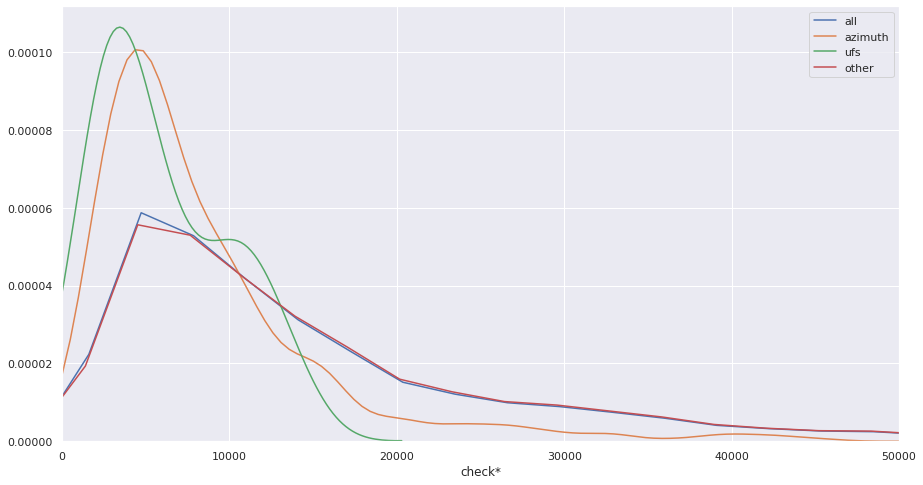

In [0]:
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 8)})
plt.xlim(0,50000)
for i in range(4):
  sns.distplot(d[d['name'].isin(part_list[i])]['check*'], norm_hist=True, kde=True, hist=False, label=dict_part_list[i][1:])


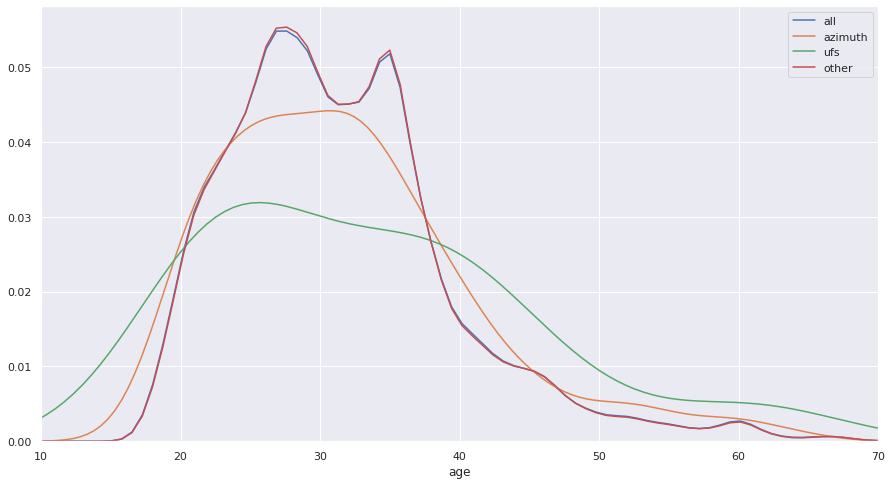

In [0]:
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 8)})
plt.xlim(10,70)
for i in range(4):
  sns.distplot(d[d['name'].isin(part_list[i])]['age'], norm_hist=True, kde=True, hist=False, label=dict_part_list[i][1:])


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:202: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


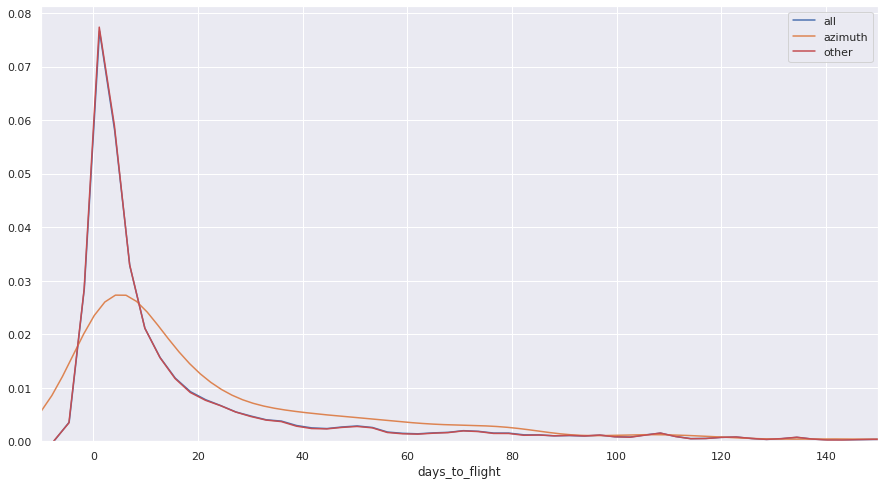

In [0]:
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 8)})
plt.xlim(-10,150)
for i in range(4):
  sns.distplot(d[d['name'].isin(part_list[i])]['days_to_flight'], norm_hist=True, kde=True, hist=False, label=dict_part_list[i][1:])


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:290: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


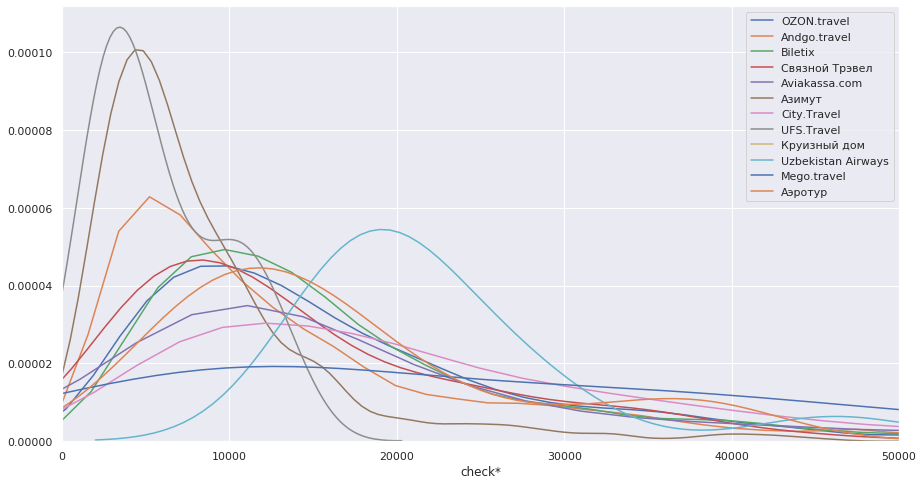

In [0]:
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 8)})
plt.xlim(0,50000)
for i in part_list[0]:
  sns.distplot(d[d['name']==i]['check*'], norm_hist=True, kde=True, hist=False, label=i)


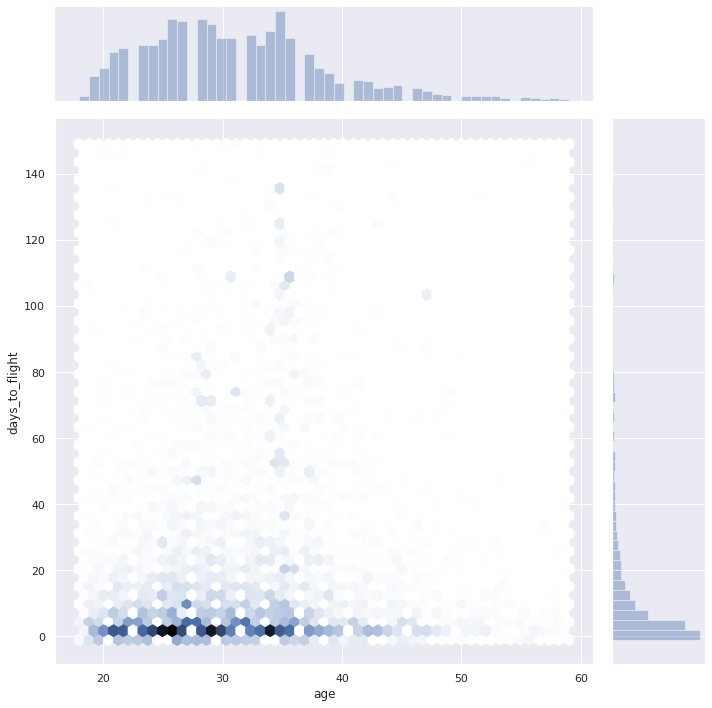

In [0]:
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 8)})
sns.jointplot(y='days_to_flight', x='age', data=d[(d['age']>15)&(d['age']<60)&(d['days_to_flight']<150)], kind='hex',height=10, ratio=5)